In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sacc

import os

os.environ["CLMM_MODELING_BACKEND"] = (
    "ccl"  # Need to use NumCosmo as CLMM's backend as well.
)
import clmm  # noqa: E402
from clmm import Cosmology  # noqa: E402

import math
import itertools

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import pyccl as ccl


## Import Redmapper Data


In [3]:
Omb = 0.02258 / 0.71**2
Omc = 0.1109 / 0.71**2


In [5]:
def generate_sacc_file() -> Any:
    """Generate a SACC file for cluster number counts and cluster deltasigma."""
    path = "/sps/lsst/groups/clusters/cl_pipeline_project/eduardo/CLCosmo_Sim_database"
    t = np.load(
        f"{path}/data/stacked_esd_profiles_redmapper_true_full_coverage.pkl",
        allow_pickle=True,
    )
    
    n_z_bins = 7
    n_rich_bins = 4
    n_radius_bins = 15
    n_cut = 4

    area = 439.78986

    
    richness_bins = np.log10(t["stacked profile"][0:n_rich_bins]["obs_bin"])
    redshift_bins = [t["stacked profile"][0 + n_rich_bins * i]["z_bin"] for i in range(n_z_bins)]
    radius_centers = t["stacked profile"][0]["radius"][n_cut:n_radius_bins]
    radius_bins = [[radius - 0.05, radius + 0.05] for radius in radius_centers]
    print(list(richness_bins), redshift_bins)

    s_count = sacc.Sacc()
    bin_z_labels = []
    bin_richness_labels = []
    bin_radius_labels = []

    survey_name = "cosmodc2"
    s_count.add_tracer("survey", survey_name, area)
    z_bins = []
    rich_bins = []
    for i, z_bin in enumerate(redshift_bins):
        lower, upper = z_bin
        bin_z_label = f"bin_z_{i}"
        s_count.add_tracer("bin_z", bin_z_label, lower, upper)
        bin_z_labels.append(bin_z_label)
        z_bins.append((lower,upper))
    for i, richness_bin in enumerate(richness_bins):
        lower, upper = richness_bin
        bin_richness_label = f"rich_{i}"
        s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
        bin_richness_labels.append(bin_richness_label)
        rich_bins.append((lower,upper))
    for i, radius_bin in enumerate(radius_bins):
        radius_lower, radius_upper = radius_bin
        j = i + 2
        radius_center = np.mean(radius_bins[i : j])
        bin_radius_label = f"bin_radius_{i}"
        s_count.add_tracer(
            "bin_radius", bin_radius_label, radius_lower, radius_upper, radius_center
        )
        bin_radius_labels.append(bin_radius_label)
    cluster_DeltaSigma = []
    mean_DeltaSigma = []
    cov_deltasigma = []
    cluster_counts = []
    for i in range(0, n_z_bins):
        for j in range(0, n_rich_bins):
            counts = t["stacked profile"][j + i * n_rich_bins]["n_stack"]
            cluster_counts.append(counts)
            # s_count.add_data_point(
            #     sacc.standard_types.cluster_counts,
            #     (survey_name, bin_z_labels[i], bin_richness_labels[j]),
            #     int(counts),
            # )
            for k in range(n_cut, n_radius_bins):
                profile = t["stacked profile"][j + i * n_rich_bins]["gt"][k]
                s_count.add_data_point(
                    sacc.standard_types.cluster_shear,
                    (
                        survey_name,
                        bin_z_labels[i],
                        bin_richness_labels[j],
                        bin_radius_labels[k-n_cut],
                    ),
                    profile,
                )
                mean_DeltaSigma.append(profile)

    counts_array = np.array(t["stacked profile"]["n_stack"])
    data = t['stacked covariance']['cov_t']
    diagonals = np.array([np.diag(matrix[n_cut:n_radius_bins,n_cut:n_radius_bins]) for matrix in data])
    cov_deltasigma = diagonals.flatten()
    cov_counts = []#counts_array.flatten()
    covariance = np.diag(np.concatenate([cov_counts, cov_deltasigma]))


    # ### Then the add the covariance and save the file
    s_count.add_covariance(covariance)
    s_count.to_canonical_order()
    s_count.save_fits("/pbs/home/e/ebarroso/CosmoPipeline/Theory Test/cosmodc2.sacc",overwrite=True)
    
    return mean_DeltaSigma, radius_centers, z_bins, rich_bins, s_count, n_z_bins, n_rich_bins, counts_array, covariance
    

if __name__ == "__main__":
    Ncm.cfg_init()
    mean_DeltaSigma_flat, rbins, z_bins, rich_bins, sac_s, nz, nr, counts, covariance = generate_sacc_file()

[array([1.30103   , 1.54406804]), array([1.54406804, 1.84509804]), array([1.84509804, 2.        ]), array([2.     , 2.30103])] [array([0.2, 0.3]), array([0.3, 0.4]), array([0.4, 0.5]), array([0.5, 0.6]), array([0.6, 0.7]), array([0.7, 0.8]), array([0.8, 1. ])]


FileNotFoundError: [Errno 2] No such file or directory: '/pbs/home/e/ebarroso/CosmoPipeline/Theory Test/cosmodc2.sacc'

## Read Sacc data

In [29]:
s_read = sacc.Sacc.load_fits("/pbs/home/e/ebarroso/CosmoPipeline/Theory Test/cosmodc2.sacc") 
data_points = s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")
mean_DeltaSigma_read = [point.value for point in s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")]
##Since we saved in redshift bins and then richness bins, this list will also be in this order
bin_DeltaSigma = [mean_DeltaSigma_read[i*len(rbins):i*len(rbins) + len(rbins)] for i in range(0, nz*nr)]
mean_DeltaSigma = [mean_DeltaSigma_flat[i*len(rbins):i*len(rbins) + len(rbins)] for i in range(0, nz*nr)]


### Comparing generated data to saved data

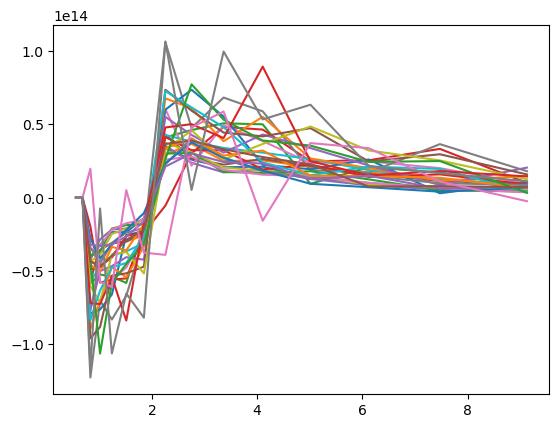

In [20]:
bin_ij = 0
for z_bin in range(nz):
    for rich_bin in range(nr):
        diff = np.array(bin_DeltaSigma[bin_ij]) - np.array(mean_DeltaSigma[bin_ij])
        plt.plot(rbins, diff)
        bin_ij+=1

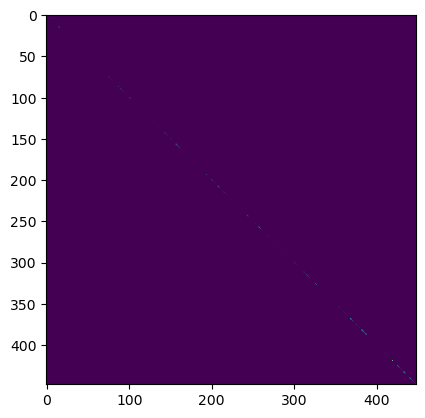

[ 0.00000000e+00  3.04000000e+02  7.87404438e+24  1.27101736e+25
  7.01666908e+25  1.50783492e+26  1.62733224e+24  2.02001904e+24
  1.60447179e+25  5.28949452e+25  4.76313088e+23  8.93146985e+23
  4.29862000e+24  3.40217980e+25  9.21612192e+25  6.67847939e+26
  4.53319010e+26  1.18656331e+25  1.85640666e+25  6.00318941e+25
  8.86645637e+25  4.86842012e+24  7.23240582e+24  3.40123693e+25
  2.44925000e+25  1.21924669e+24  1.93792636e+24  1.05623907e+25
 -3.36948721e+25 -2.54133701e+25 -1.82359486e+25 -1.25729973e+25
 -7.87404438e+24 -5.32042138e+24 -4.37312519e+24 -2.10303513e+24
 -2.06139015e+24 -1.39992305e+24 -9.86604112e+23 -4.87021726e+23
 -6.59507722e+23 -4.70864418e+23 -3.96099232e+23 -8.49295467e+25
 -5.07645926e+25 -4.04996947e+25  1.94051217e+25  6.39471432e+24
  5.52577498e+24  6.60578547e+24 -3.31241165e+24 -3.40437116e+24
 -3.16183318e+24 -2.81188381e+24 -1.58637410e+24 -1.32961379e+24
 -1.13864215e+24 -5.84881741e+23 -4.37838328e+26 -2.64071445e+26
 -1.36985345e+26 -1.48787

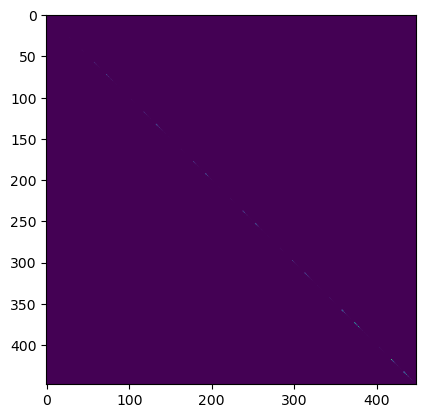

In [21]:
plt.imshow(s_read.covariance.covmat)
plt.show()
plt.imshow(covariance)
print(np.diagonal(s_read.covariance.covmat - covariance))
print(np.diagonal(s_read.covariance.covmat))
print(np.diagonal(covariance))

In [22]:
from firecrown.models.cluster.recipes.murata_binned_spec_z_deltasigma import MurataBinnedSpecZDeltaSigmaRecipe as MDS
from firecrown.models.cluster.deltasigma import ClusterDeltaSigma
from firecrown.models.cluster.deltasigma_data import DeltaSigmaData
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.binning import SaccBin
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts_deltasigma import BinnedClusterDeltaSigma

## Initiating mass function and defining parameters

In [23]:
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")
min_mass, max_mass = 12.5, 15.5
min_z, max_z = 0.01, 1.2
cluster_abundance = ClusterAbundance((min_mass, max_mass), (min_z, max_z), hmf)
cluster_deltasigma = ClusterDeltaSigma((min_mass, max_mass), (min_z, max_z), hmf, False)
cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
sky_area = 400

## Reading data from SACC

### Calling functions by hand

In [24]:
DSD = DeltaSigmaData(s_read)
survey_nm = "cosmodc2"
data_type = sacc.standard_types.cluster_shear
##CHECK THIS ONE TOO
bin_combinations_for_survey = DSD._all_bin_combinations_for_data_type_and_survey(survey_nm, data_type, 4)
#print(bin_combinations_for_survey)
bins = []
for _, z_tracer, mass_tracer, radius_tracer in bin_combinations_for_survey:
    z_data: sacc.tracers.BinZTracer = sac_s.get_tracer(z_tracer)
    mass_data: sacc.tracers.BinRichnessTracer = sac_s.get_tracer(
        mass_tracer
    )
    radius_data: sacc.tracers.BinRadiusTracer = sac_s.get_tracer(
        radius_tracer
    )

    sacc_bin = SaccBin([z_data, mass_data, radius_data])
    bins.append(sacc_bin)

## Updating parameters in Notebook

In [25]:
cluster_deltasigma.update_ingredients(cosmo_ccl)
cluster_abundance.update_ingredients(cosmo_ccl)
mds = MDS()

mds.mass_distribution.__setattr__('mu_p0', 3.35)
mds.mass_distribution.__setattr__('mu_p1', 2.23 / np.log(10))
mds.mass_distribution.__setattr__('mu_p2', 0.06)
mds.mass_distribution.__setattr__('sigma_p0', 0.56)
mds.mass_distribution.__setattr__('sigma_p1', 0.10/ np.log(10))
mds.mass_distribution.__setattr__('sigma_p2', -0.05)
mds.mass_distribution.pivot_mass = np.log(10**14.3) 
mds.mass_distribution.pivot_redshift = 0.5
print(mds.mass_distribution.pivot_mass)
print(2.23 / np.log(10), 0.1 / np.log(10))

32.92696682981485
0.9684766946442517 0.04342944819032519


### Initiating statistic object from firecrown

In [26]:


bin_cl_theory = BinnedClusterDeltaSigma(ClusterProperty.DELTASIGMA, survey_nm, mds)
bin_cl_theory.read(s_read)

for i in range(len(bins)):
    print(f"{bin_cl_theory.bins[i].__str__().__eq__( bins[i].__str__())}\n")
    print(bin_cl_theory.bins[i].__str__())


True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (0.5072350017377727, 0.6072350017377728)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (0.6303421477531161, 0.7303421477531162)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (4.054121773679276, 4.154121773679275)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (4.9614783570513925, 5.061478357051392)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (6.069096535179117, 6.169096535179117)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (7.4205052937743075, 7.520505293774307)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (9.074444023452758, 9.174444023452759)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (0.7803322007321918, 0.8803322007321919)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (0.9641801886136445, 1.0641801886136446)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (1.18833109

### Computing profile notebook

In [12]:

eval_list = []
eval_total = []
counts_total = []
for this_bin in bins:
    eval_u = mds.evaluate_theory_prediction(cluster_deltasigma,this_bin, sky_area, ClusterProperty.DELTASIGMA)
    eval_c = mds.evaluate_theory_prediction_counts(cluster_deltasigma,this_bin, sky_area)    
    eval_total.append(eval_u)
    counts_total.append(eval_c)
    eval_list.append(eval_u / eval_c)
eval_list = np.array(eval_list)
print(counts_total)

[147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 147.37413737558796, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 66.67874409579134, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 12.296214913918714, 8.29920316101337, 8.29920316101337, 8.29920316101337, 8.29920316101337, 8.29920316101337, 8.29920316101337, 8.2992

### Computing profile Firecrown

In [13]:
from firecrown.modeling_tools import ModelingTools
tools = ModelingTools(cluster_abundance=cluster_abundance, cluster_deltasigma=cluster_deltasigma)

firecrown_pred = bin_cl_theory.get_binned_cluster_property(tools, ClusterProperty.DELTASIGMA)
firecrown_pred = np.array(firecrown_pred) 

In [14]:
truth_data = np.array(bin_DeltaSigma).flatten() #np.array(mean_DeltaSigma).flatten()
diff_nd =  (eval_list - truth_data) / truth_data
diff_nf = (eval_list - firecrown_pred) / firecrown_pred
diff_fd = (firecrown_pred - truth_data) / truth_data
print(f"Dfference between Notebook and data {diff_nd}")
print(f"Dfference between Notebook and Firecrown {diff_nf}")
print(f"Dfference between Firecrown and data {diff_fd}")

Dfference between Notebook and data [ 4.68225499e-02 -1.42150093e-01 -5.88834151e-02  2.35899006e-01
 -8.07836750e-02 -2.42328939e-01 -9.85615343e-02 -1.49693110e-01
 -1.09910911e-01 -6.91299820e-02 -2.69967445e-01 -7.92784610e-02
 -1.28478050e-01 -9.01518956e-02  1.05379517e-01  1.84359831e-02
 -1.22056722e-01 -1.71956118e-01 -3.61038300e-01 -3.13190835e-01
 -3.01574984e-01 -2.53352160e-01  6.45415618e-02 -1.57737306e-01
 -3.91243496e-02 -1.77754047e-01 -2.57608302e-01 -2.75318697e-01
 -2.32576128e-01 -2.15314025e-01 -1.89814471e-01 -1.01561338e-01
  1.09737417e-01 -3.46976646e-01 -3.93258123e-02  3.08733261e+00
  9.65847719e-01  1.01056869e-01 -5.23425111e-02 -1.81041760e-01
 -3.44904413e-01  4.38154733e-01 -1.16047339e-01 -6.31213003e-03
  5.07445047e-01  1.73494030e-01 -1.54884250e-02  2.16706439e-01
  2.89529910e-01 -3.06248177e-01  1.24873840e+00 -4.39284668e-01
  1.98910577e+00  1.57091024e-01 -7.42563343e-02 -1.38363719e-01
  2.00895940e-01 -1.59221703e-01 -3.38742472e-01 -3.62

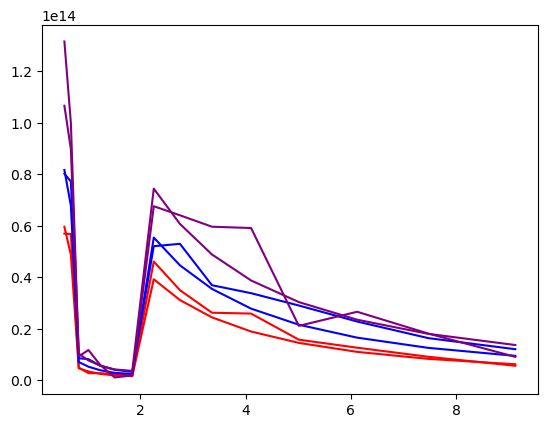

In [15]:
interval = len(rbins)
color = ['red', 'blue','purple']
for i in range(0,3):
    #plt.plot(rbins, firecrown_pred[i*interval : i*interval + interval], color=color[i])
    plt.plot(rbins, eval_list[i*interval : i*interval + interval], color=color[i])
    plt.plot(rbins, truth_data[i*interval : i*interval + interval], color=color[i])